In [1]:
import os

img_dir='/tmp/nst'                           # images are stored in this dir
if not os.path.exists(img_dir):
    os.makedir(img_dir)

In [2]:
print(os.getcwd())

C:\Users\Admin


# Import Modules

In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from PIL import Image                   
import functools

In [2]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models
from tensorflow.python.keras import layers

In [3]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [4]:
# set image paths to load them 

content_path = '/tmp/nst/ronaldo.jpg'
style_path = '/tmp/nst/starry_night.jpg'

# Visualize Input

In [10]:
def load_img(path_to_img):
    max_dim=512
    img=Image.open(path_to_img)
    longg=max(img.size)
    scale=max_dim/longg
    img=img.resize((round(img.size[0]*scale),round(img.size[1]*scale)),Image.ANTIALIAS)      
    
    img=kp_image.img_to_array(img)
    img=np.expand_dims(img,axis=0)    # Expand the shape of an array.
                                      # Insert a new axis that will appear at the axis position in the expanded array shape.
 
    return img
    
    

In [11]:
def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

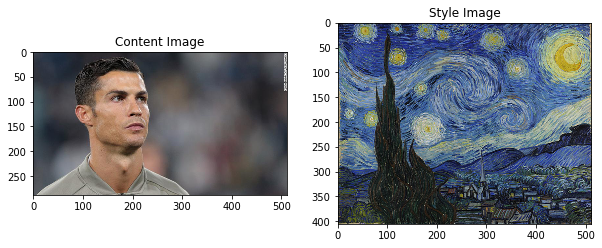

In [12]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

# Preparing the data

In [13]:
def load_and_preprocess_img(path_to_img):
    img=load_img(path_to_img)
    img=tf.keras.applications.vgg19.preprocess_input(img)     # apply the same preprocesing as req. for vgg19
    return img

In [14]:
 #to undo the preprocessing applied for vgg19, to get back the orig. images
def deprocess_img(processed_img):          
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

# Content and Style layers

In [15]:
content_layers=['block5_conv2']

style_layers=['block1_conv1',
              'block2_conv1',
              'block3_conv1',
              'block4_conv1',
              'block5_conv1'
             ]

num_style_layers=len(style_layers)
num_content_layers=len(content_layers)


# Model to generate feature representations

In [16]:
def get_model():
    vgg=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
    vgg.trainable=False
    
    style_outputs=[vgg.get_layer(name).output for name in style_layers]
    content_outputs=[vgg.get_layer(name).output for name in content_layers]
    
    outputs=style_outputs+content_outputs
    
    return models.Model(vgg.input,outputs)

# Content Loss

In [17]:
def get_content_loss(base_input,content_target):
    return tf.reduce_mean(tf.square(base_input-content_target))

# Style Loss

In [18]:
def gram_matrix(base_input_tensor):
    channels=int(base_input_tensor.shape[-1])
    a=tf.reshape(base_input_tensor,[-1,channels])
    n=tf.shape(a)[0]
    
    gram=tf.matmul(a,a,transpose_a=True)
    gram=gram/tf.cast(n,tf.float32)
    return gram

def get_style_loss(base_input,target_gram):               # base_input is a tensor
    height,weight,channels=base_input.shape
    base_gram=gram_matrix(base_input)
    
    return tf.reduce_mean(tf.square(base_gram-target_gram))
    

#  Generating feature representations

In [19]:
def feature_reps(model,content_path,style_path):                              # for generating feature reps of target images
    content_img=load_and_preprocess_img(content_path)
    style_img=load_and_preprocess_img(style_path)
    
    style_outputs=model(style_img)
    content_outputs=model(content_img)
    
    style_features=[style_feature[0] for style_feature in style_outputs[:num_style_layers]]
    content_features=[content_feature[0] for content_feature in content_outputs[num_style_layers:]]
    
    return style_features, content_features


# Compute loss for input image

In [20]:
def compute_loss(model, loss_weights, init_image, gram_style_target,target_content_features):
    
    style_weight, content_weight= loss_weights
    
    model_outputs=model(init_image)
    
    init_style_features=model_outputs[:num_style_layers]
    init_content_features=model_outputs[num_style_layers:]
    
    style_loss=0
    content_loss=0
    
    weight_per_style_layer = 1.0/float(num_style_layers)
    for target_style, init_style in zip(gram_style_target, init_style_features):
        style_loss += weight_per_style_layer * get_style_loss(init_style[0],target_style)
    
    weight_per_content_layer= 1.0/float(num_content_layers)
    for target_content, init_content in zip(target_content_features, init_content_features):
        content_loss += weight_per_content_layer * get_content_loss(init_content[0],target_content)
        
    loss=(content_weight*content_loss) + (style_weight*style_loss)
    
    return loss, style_loss, content_loss 
        
    

# Compute gradients

In [21]:
def compute_grads(config):
    with tf.GradientTape() as tape:                    # GradientTape() records operations for automatic differentiation.
        all_loss=compute_loss(**config)
    
    total_loss=all_loss[0]
    
    return tape.gradient(total_loss,config['init_image']), all_loss

# Optimization

In [23]:
import IPython.display

def run_optimization(content_path, style_path, num_iterations=800, style_weight=1e-2, content_weight=1e3):
    model=get_model()
    for layer in model.layers:
        layer.trainable=False
    
    target_style_features, target_content_features= feature_reps(model,content_path,style_path)
    gram_style_target = [gram_matrix(target_style_feature) for target_style_feature in target_style_features]
    
    # define init_image
    init_image=load_and_preprocess_img(content_path)
    init_image=tfe.Variable(init_image, dtype=tf.float32)
    
    opt=tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
    
    loss_weights=(style_weight, content_weight)
    
    best_loss, best_image=float('inf'), None
    
    config={
            'model':model,
            'loss_weights':loss_weights,
            'init_image':init_image,
            'gram_style_target':gram_style_target,
            'target_content_features':target_content_features
           }
    
    # to display the intermediate images
    no_rows=2
    no_cols=5
    interval=num_iterations/(no_rows*no_cols)
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means
    
    imgs=[]
    
    for i in range(num_iterations):
        grads, all_loss=compute_grads(config)
        total_loss, style_loss, content_loss=all_loss
        opt.apply_gradients([(grads,init_image)])
        clipped=tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        
        if total_loss < best_loss:
            best_loss=total_loss
            best_image=deprocess_img(init_image.numpy())
        
        # displaying
        
        if i % interval == 0:
            plot_img = init_image.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
        print('Iteration: {}'.format(i))        
        print('Total loss: {:.4e}, ' 
              'style loss: {:.4e}, '
              'content loss: {:.4e}'.format(total_loss,style_loss,content_loss))
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    for i,img in enumerate(imgs):
        plt.subplot(no_rows,no_cols,i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
      
    return best_image, best_loss 
        

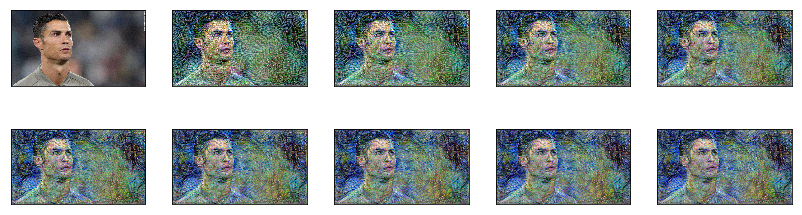

In [48]:
best, best_loss = run_optimization(content_path, 
                                     style_path, num_iterations=800)

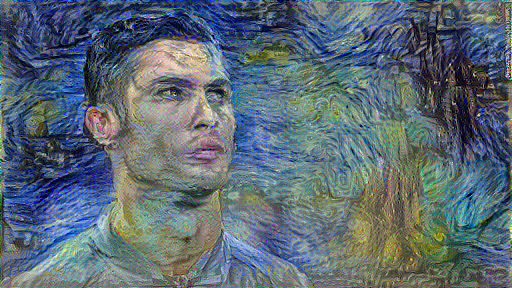

In [49]:
Image.fromarray(best)

In [50]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

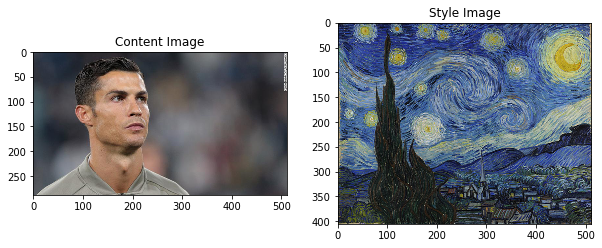

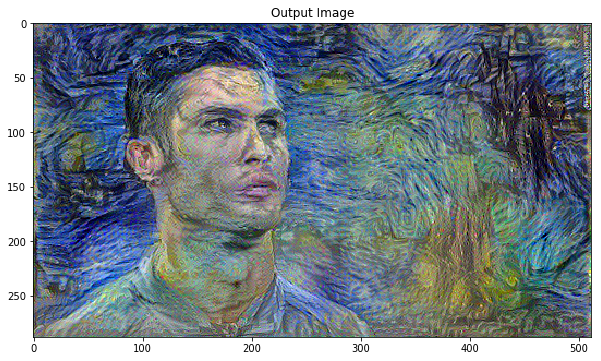

In [51]:
show_results(best, content_path, style_path)